In [54]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import r2_score 


# load data
df = pd.read_excel('2022_HiMCM_Data-B-co2.xlsx',sheet_name="origin")
year = df['Year'].tolist()
degree = df['Degree'].tolist()

yearstart = year[0]
yearend = year[-1]

print("year range: %d -> %d" %(yearstart, yearend))


year range: 1959 -> 2021


In [55]:
# degree = 2 (2次多项式)
coef = np.polyfit(year, degree, 2)
degree_fit= np.polyval(coef, year)

R_square = r2_score(degree, degree_fit) 
print('Coefficient of Determination (R^2): ', R_square) 

# y = ax^2 + bx + c
a = coef[0]
b = coef[1]
c = coef[2]

def get_poly2(year):
    return a * year * year + b * year + c

print("Prediction function: \ndegree = (%.4f) * Year^2 + (%.4f) * Year + (%.4f)"%(a,b,c))



Coefficient of Determination (R^2):  0.9194801266755249
Prediction function: 
degree = (0.0002) * Year^2 + (-0.6175) * Year + (597.9998)


In [56]:
fig = go.Figure()
fig.add_traces(go.Scatter(x=year, y=degree, mode = "markers", name = "real data"))
fig.add_traces(go.Scatter(x=year, y=degree_fit, mode = "lines", name = "fitted line"))
fig.update_layout( 
        title='Degree Increment with Years',
        title_x=0.5,
        # autosize=False,
        width=1500,
        height=700,
    )
fig.show()

In [57]:
deviation = np.empty(0,dtype=np.float64)


for i in range(yearstart, yearend-1):
    pdict = get_poly2(i)
    dd = pdict - degree[i-yearstart]  #difference
    deviation = np.append(deviation, dd)


avg = np.average(deviation)
std = np.std(deviation, ddof=1)
print("avg = %.10f, std = %.10f" %(avg, std))

go.Figure(data=[go.Histogram(x=deviation)]).show()

avg = -0.0009729115, std = 0.0917525781


In [254]:

yend_true_end = yearend
year_predict_end = 2101


all_years = np.linspace(yearstart, year_predict_end-1,year_predict_end - yearstart )


# pdict = np.empty(0,dtype=np.float64)
# pdict_scatter = np.empty(0,dtype=np.float64)

degree_predict  = np.polyval(coef, all_years[yend_true_end-yearstart+1:] )

# add normal noise
for y in range(0, year_predict_end - yend_true_end - 1):
    degree_predict[y] += np.random.normal(avg, std)


pdict_line      = np.polyval(coef, all_years) 


fig = go.Figure()
fig.add_traces(go.Scatter(x=all_years[:yend_true_end-yearstart+1], y=degree,mode = "markers", name = "actual data (1959-2021)"))
fig.add_traces(go.Scatter(x=all_years[yend_true_end-yearstart+1:], y=degree_predict,mode = "markers",  name = "predict data after (2022->)"))

fig.add_traces(go.Scatter(x=all_years, y=pdict_line, mode = "lines", name = "predict line"))


all_degrees = np.append(degree, degree_predict)
fig.add_traces(go.Scatter(x=all_years, y=all_degrees, mode = "lines", name = "all data"))


fig.update_layout(
        xaxis = dict(
            title = "Year"
        ),
        yaxis = dict(
            title = "Degree(Celcius)"
        ),
        title='Degree Increment with Years',
        title_x=0.5,
        # autosize=False,
        width=1800,
        height=800,
    )
fig.show()



In [156]:
predict_degree_series = pd.Series(pdict_scatter)

fig = go.Figure()
fig.add_traces(go.Scatter(x=all_years, y=predict_degree_series.diff(1), mode = "lines", name = "Degree_diff(1)"))

fig.update_layout( 
        title='Degree/Year (1-order differenced data)',
        title_x=0.5,
        # autosize=True,
        width=1000,
        height=500,
    )

fig.show()

In [157]:
from statsmodels.tsa.stattools import adfuller



from numpy import log

print("\ndegree ")

result = adfuller(predict_degree_series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(predict_degree_series.diff(1).dropna())
print('ADF Statistic: %f' % result[0])
print('1d -> p-value: %f' % result[1])




degree 
ADF Statistic: 4.181852
p-value: 1.000000
ADF Statistic: -1.626790
1d -> p-value: 0.469171


In [115]:
from pmdarima.arima.utils import ndiffs

y = predict_degree_series
# y = ppm


## Adf Test
print(ndiffs(y, test='adf'))  # 2

# KPSS test
print(ndiffs(y, test='kpss'))  # 0

# PP test:
print(ndiffs(y, test='pp'))  # 2

1
2
1


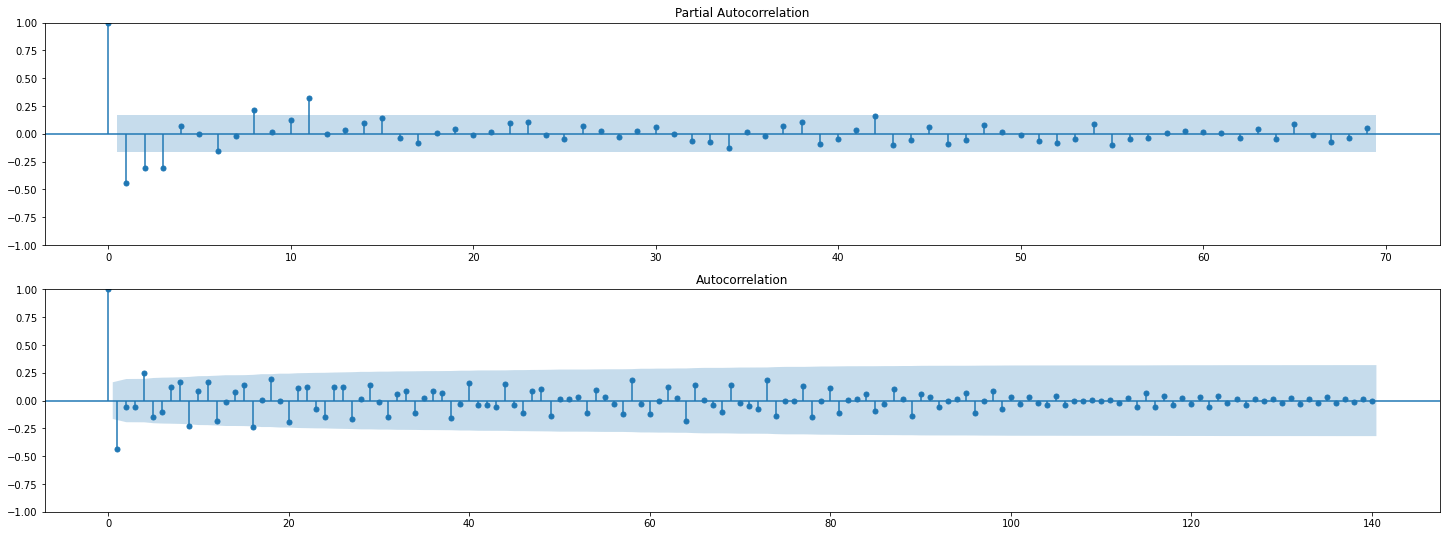

In [132]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, adfuller, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ddd = 1

fig = plt.figure(figsize=(25, 9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# ax3 = fig.add_subplot(313)


# plot_pacf(predict_degree_series.diff(ddd).dropna(), method='ols', lags=(len(predict_degree_series) - ddd - 1)/2 -1, ax=ax1)
plot_pacf(predict_degree_series.diff(ddd).dropna(),  method='ywm', lags=(len(predict_degree_series) - ddd - 1)/2 -1, ax=ax1)

plot_acf(predict_degree_series.diff(ddd).dropna(), lags=len(predict_degree_series) - ddd - 1, ax=ax2)


plt.show()


# p = 1,2,3 ... 10
# d = 1
# q = 1, 4



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  142
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 100.355
Date:                Tue, 15 Nov 2022   AIC                           -190.710
Time:                        21:47:29   BIC                           -175.967
Sample:                             0   HQIC                          -184.719
                                - 142                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9869      0.346     -2.854      0.004      -1.664      -0.309
ar.L2         -0.4603      0.163     -2.820      0.005      -0.780      -0.140
ar.L3         -0.2354      0.077     -3.064      0.0

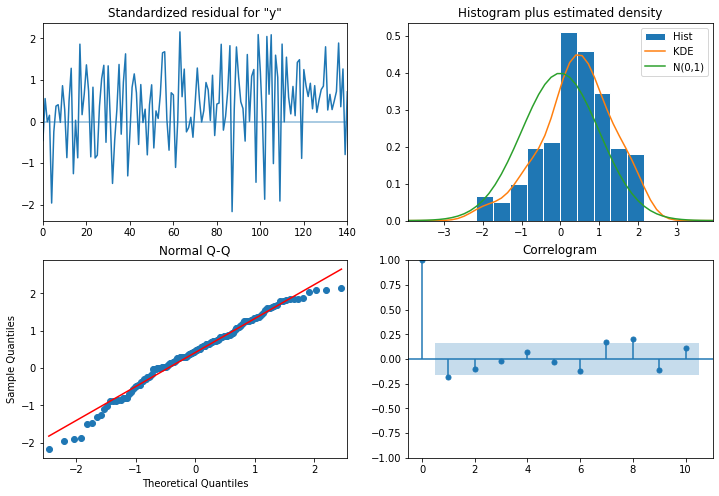

In [162]:
import statsmodels.api as sm

# 2,1,1 ARIMA Model (p,d,q)
modelfit = sm.tsa.ARIMA(predict_degree_series.dropna().to_numpy(), order=(3, 1,1)).fit()  # 默认使用最小二乘generalized least squares(GLS)，
print(modelfit.summary())
modelfit.plot_diagnostics(figsize=(12,8))
plt.show()

# p = 1,2,3 ... 10
# d = 1
# q = 1, 4


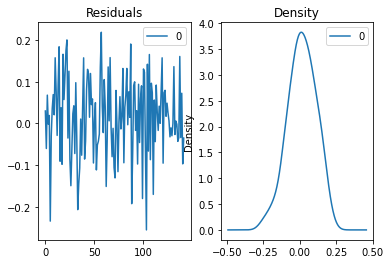

NormaltestResult(statistic=array([1.9034369]), pvalue=array([0.386077]))

In [143]:
import scipy.stats as stats

# Plot residual errors
residuals = pd.DataFrame(modelfit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
stats.normaltest(residuals)

In [149]:
# # Actual vs Fitted
from statsmodels.graphics.tsaplots import plot_predict
# plot_predict(modelfit.get_prediction, dynamic=False)

modelfit_predict = sm.tsa.ARIMA(predict_degree_series.dropna().to_numpy(), order=(10, 1, 4)).fit()

forecast = modelfit_predict.predict(dynamic=False)

figp = go.Figure()
figp.add_traces(go.Scatter(x=all_years, y=predict_degree_series, mode = "lines", name = "Actual"))
figp.add_traces(go.Scatter(x=all_years, y=forecast, mode = "lines", name = "Fitted"))

figp.update_layout( 
        title='Actual vs Fitted',
        title_x=0.5,
        autosize=False,
        width=1800,
        height=700,
    )

figp.show()


c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



142
134


c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\bzhu5\AppData\Lo

[3.6803512352220213, 3.731724973647575, 3.7849013063386696, 3.823125475613382, 3.9102474502943254, 3.999051711920605, 4.023155438292156, 4.084484215722581]


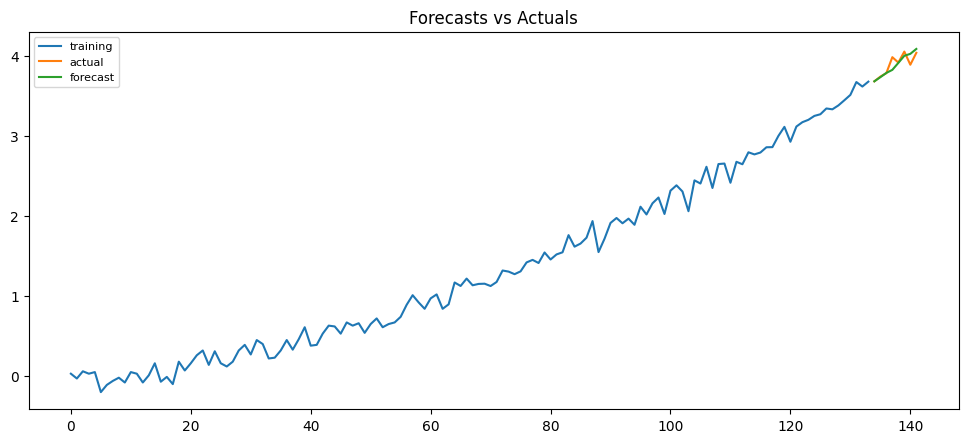

{'mape': 0.012928179207255069,
 'me': -0.004361941158901483,
 'mae': 0.05117155537923607,
 'mpe': -0.0009952674692008789,
 'rmse': 0.07806865759321859,
 'acf1': -0.00949953277862463,
 'corr': 0.8316349445879492,
 'minmax': 0.012762849890571637}

In [151]:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# from statsmodels.tsa.stattools import acf

# Create Training and Test -  split the data into train (80%) and test (20%).
train_len = int(len(predict_degree_series)*0.95)
train = predict_degree_series[:train_len]
test = predict_degree_series[train_len:]


print(len(predict_degree_series))
print(train_len)

history = [x for x in train]
predictions = list()


for t in range(len(test)):
    model = sm.tsa.ARIMA(history, order=(10,1,4))
    model_fit = model.fit()
    pred = model_fit.forecast(steps=1)
    yhat = pred[0]
    predictions.append(yhat)
    # Append test observation into overall record
    obs = test[t+train_len]
    history.append(obs)


print(predictions)


# Make as pandas series
fc_series = pd.Series(predictions, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='k', alpha=.15)
plt.title('Forecasts vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(np.array(predictions), test.values)

In [154]:

# Build Model to train the values

modelfit_future = sm.tsa.ARIMA(predict_degree_series.dropna().to_numpy(), order=(10, 1, 4)).fit()



# print(modelfit_future.summary())


ystart = 1975
yend_true_data = 2100
yend = 2110

predict = modelfit_future.predict(start =0, end = yend_true_data - ystart, dynamic=False)

# print(type(predict))
print(len(predict))

# # Forecast year = 30
future_year = yend - yend_true_data + 1
forecast_year = modelfit_future.forecast(steps=future_year) 
# print(forecast_year)

predict = np.append(predict, forecast_year)

yearlong = np.linspace(ystart, yend-1,yend - ystart )

fig_future = go.Figure()
fig_future.add_traces(go.Scatter(x=yearlong[:yend_true_data-ystart+1], y=degree, name = "actual data"))
# fig_future.add_traces(go.Scatter(x=yearlong[yend_true_data-ystart+1:], y=forecast_year, name = "predict data"))
fig_future.add_traces(go.Scatter(x=yearlong, y=predict, name = "predict data"))


fig_future.update_layout(
        xaxis = dict(
            title = "Year"
        ),
        yaxis = dict(
            title = "Degree(Celcius)"
        ),
        title='Degree Increment with Years',
        title_x=0.5,
        autosize=True,
        width=1500,
        height=900,
    )
fig_future.show()




126


c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-221.202, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-173.907, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-202.128, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-223.013, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-169.203, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-221.291, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-219.048, Time=0.72 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-190.776, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.887 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  142
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 114.507
Date:                Tue, 15 Nov 2022   AIC                           -223.013
Time:                        21:46:0

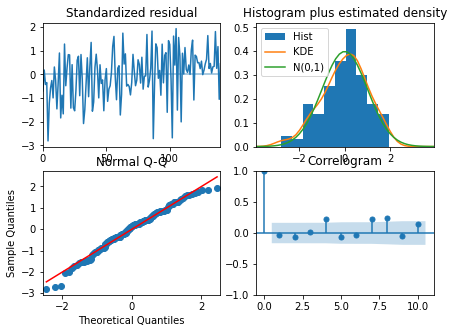

In [155]:
import pmdarima as pm


model = pm.auto_arima(predict_degree_series, start_p=1, start_q=1,
                      test='adf',       # use adftest (adf) to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


# model = pm.auto_arima(degree)


print(model.summary())

model.plot_diagnostics(figsize=(7,5))
plt.show()